In [3]:
from astroquery.gaia import Gaia

In [4]:
import astropy.units as u
from astropy.coordinates import SkyCoord

ra = 88.8 * u.degree
dec = 7.4 * u.degree
coord_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs')
coord_icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (88.8, 7.4)>

In [5]:
from gala.coordinates import GD1Koposov10

gd1_frame = GD1Koposov10()
gd1_frame

<GD1Koposov10 Frame>

In [6]:
coord_gd1 = coord_icrs.transform_to(gd1_frame)
coord_gd1

<SkyCoord (GD1Koposov10): (phi1, phi2) in deg
    (-94.97222038, 34.5813813)>

In [7]:
phi1_min = -55 * u.degree 
phi1_max = -45 * u.degree
phi2_min = -8 * u.degree
phi2_max = 4 * u.degree

In [8]:
def make_rectangle(x1, x2, y1, y2):
    """Return the corners of a rectangle."""
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    return xs, ys

In [9]:
phi1_rect, phi2_rect = make_rectangle(phi1_min, phi1_max, phi2_min, phi2_max)

In [10]:
corners = SkyCoord(phi1=phi1_rect, phi2=phi2_rect, frame=gd1_frame)
corners

<SkyCoord (GD1Koposov10): (phi1, phi2) in deg
    [(-55., -8.), (-55.,  4.), (-45.,  4.), (-45., -8.), (-55., -8.)]>

In [11]:
corners_icrs = corners.transform_to('icrs')
corners_icrs

<SkyCoord (ICRS): (ra, dec) in deg
    [(146.27533314, 19.26190982), (135.42163944, 25.87738723),
     (141.60264825, 34.3048303 ), (152.81671045, 27.13611254),
     (146.27533314, 19.26190982)]>

In [12]:
def skycoord_to_string(skycoord):
    """Convert a one-dimenstional list of SkyCoord to string for Gaia's query format."""
    corners_list_str = skycoord.to_string()
    corners_single_str = ' '.join(corners_list_str)
    return corners_single_str.replace(' ', ', ')

In [13]:
sky_point_list = skycoord_to_string(corners_icrs)
sky_point_list

'146.275, 19.2619, 135.422, 25.8774, 141.603, 34.3048, 152.817, 27.1361, 146.275, 19.2619'

Assembling the Query

In [14]:
columns = 'source_id, ra, dec, pmra, pmdec, parallax'

In [15]:
polygon_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
"""

In [19]:
polygon_query = polygon_query_base.format(columns=columns, 
                          sky_point_list=sky_point_list)
print(polygon_query)

SELECT
source_id, ra, dec, pmra, pmdec, parallax
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(146.275, 19.2619, 135.422, 25.8774, 141.603, 34.3048, 152.817, 27.1361, 146.275, 19.2619))



In [21]:
polygon_job = Gaia.launch_job_async(polygon_query)
print(polygon_job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=140339>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
 parallax float64      mas                                                           Parallax
Jobid: 1681294942042O
Phase: COMPLETED
Owner: None
Output file: async_20230412155222.vot
Results: None


In [22]:
polygon_results = polygon_job.get_results()
len(polygon_results)

140339

In [23]:
filename = 'gd2_results.fits'
polygon_results.write(filename, overwrite=True)

# Plotting

In [24]:
polygon_results.info()

<Table length=140339>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
 parallax float64      mas                                                           Parallax


In [25]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'dec (degree ICRS)')

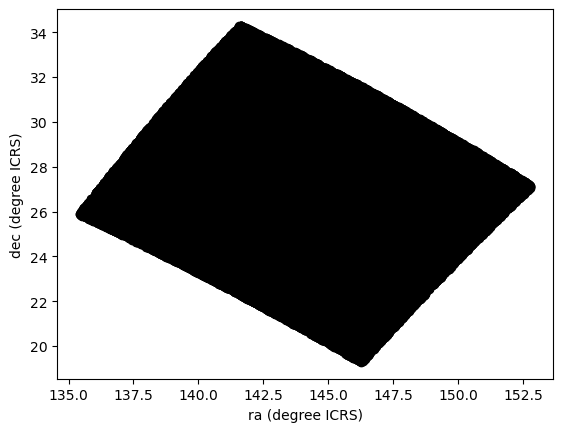

In [26]:
x = polygon_results['ra']
y = polygon_results['dec']
plt.plot(x, y, 'ko')

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')

# Transform Back

Before we go any further, we will take all of the steps that we have done and consolidate them into a single function that we can use to 
* take the coordinates and proper motion that we get as an Astropy Table from our Gaia query
* add columns representing the reflex corrected GD-1 coordinates and proper motions, and 
* transform it into a Pandas DataFrame. 
This is a general function that we will use multiple times as we build different queries so we want to write it once and then call the function rather than having to copy and paste the code over and over again.

In [29]:
from gala.coordinates import reflex_correct

In [30]:
def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    #Create a SkyCoord object with the coordinates and proper motions
    # in the input table
    skycoord = SkyCoord(
               ra=table['ra'], 
               dec=table['dec'],
               pm_ra_cosdec=table['pmra'],
               pm_dec=table['pmdec'], 
               distance=8*u.kpc, 
               radial_velocity=0*u.km/u.s)

    # Define the GD-1 reference frame
    gd1_frame = GD1Koposov10()

    # Transform input coordinates to the GD-1 reference frame
    transformed = skycoord.transform_to(gd1_frame)

    # Correct GD-1 coordinates for solar system motion around galactic center
    skycoord_gd1 = reflex_correct(transformed)

    #Add GD-1 reference frame columns for coordinates and proper motions
    table['phi1'] = skycoord_gd1.phi1
    table['phi2'] = skycoord_gd1.phi2
    table['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
    table['pm_phi2'] = skycoord_gd1.pm_phi2

    # Create DataFrame
    df = table.to_pandas()

    return df

In [31]:
results_df = make_dataframe(polygon_results)

#  Saving the DataFrame

Then we could write the Table to a FITS file, as we did in the previous lesson.

But, like Astropy, Pandas provides functions to write DataFrames in other formats; to see what they are find the functions here that begin with to_.

One of the best options is HDF5, which is Version 5 of Hierarchical Data Format.

HDF5 is a binary format, so files are small and fast to read and write (like FITS, but unlike XML).

An HDF5 file is similar to an SQL database in the sense that it can contain more than one table, although in HDF5 vocabulary, a table is called a Dataset. (Multi-extension FITS files can also contain more than one table.)

And HDF5 stores the metadata associated with the table, including column names, row labels, and data types (like FITS).

Finally, HDF5 is a cross-language standard, so if you write an HDF5 file with Pandas, you can read it back with many other software tools (more than FITS).

We can write a Pandas DataFrame to an HDF5 file like this:

In [32]:
from astropy.table import Table

results_table = Table.from_pandas(results_df)
type(results_table)

astropy.table.table.Table

In [33]:
filename = 'gd1_data.hdf'

results_df.to_hdf(filename, 'results_df', mode='w')

In [34]:
results_df.describe()

,source_id,ra,dec,pmra,pmdec,parallax,phi1,phi2,pm_phi1,pm_phi2
count,1.403390e+05,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000
mean,6.792399e+17,143.823122,26.780285,-2.484404,-6.100777,0.179492,-50.091158,-1.803301,-0.868963,1.409208
std,3.792177e+16,3.697850,3.052592,5.913939,7.202047,0.759590,2.892344,3.444398,6.657714,6.518615
min,6.214900e+17,135.425699,19.286617,-106.755260,-138.065163,-15.287602,-54.999989,-8.029159,-115.275637,-161.150142
25%,6.443517e+17,140.967966,24.592490,-5.038789,-8.341561,-0.035981,-52.602952,-4.750426,-2.948723,-1.107128
50%,6.888060e+17,143.734409,26.746261,-1.834943,-4.689596,0.362708,-50.147362,-1.671502,0.585037,1.987149
75%,6.976579e+17,146.607350,28.990500,0.452893,-1.937809,0.657637,-47.593279,1.160514,3.001768,4.628965
max,7.974418e+17,152.777393,34.285481,104.319923,20.981070,0.999957,-44.999985,4.014609,39.802471,79.275199


# Plot proper motion

In this figure, the shaded area identifies stars that are likely to be in GD-1 because:

Due to the nature of tidal streams, we expect the proper motion for stars in GD-1 to be along the axis of the stream; that is, we expect motion in the direction of phi2 to be near 0.

In the direction of phi1, we do not have a prior expectation for proper motion, except that it should form a cluster at a non-zero value.

By plotting proper motion in the GD-1 frame, we hope to find this cluster. Then we will use the bounds of the cluster to select stars that are more likely to be in GD-1.

The following figure is a scatter plot of proper motion, in the GD-1 frame, for the stars in results_df.

Text(0, 0.5, 'Proper motion phi2 (mas/yr GD1 frame)')

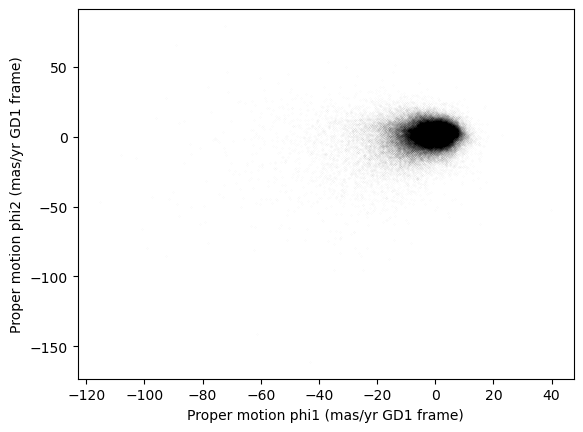

In [35]:
x = results_df['pm_phi1']
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)
    
plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

Most of the proper motions are near the origin, but there are a few extreme values. Following the example in the paper, we will use xlim and ylim to zoom in on the region near the origin.

(-10.0, 10.0)

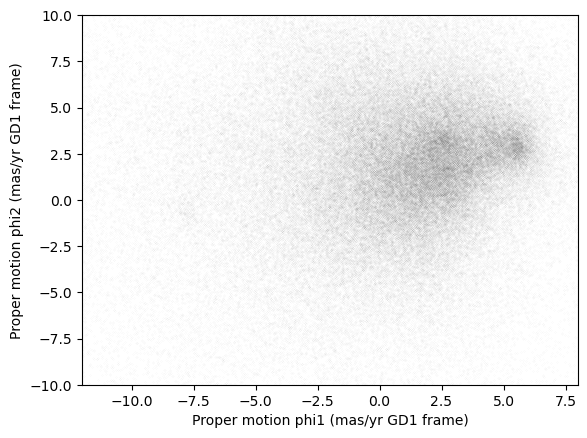

In [36]:
x = results_df['pm_phi1']
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)
    
plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10)

# Selecting the centerline

In [37]:
phi2 = results_df['phi2']
type(phi2)

pandas.core.series.Series

In [40]:
phi2_min = -1.0 * u.degree
phi2_max = 1.0 * u.degree

mask = mask = (phi2 > phi2_min) & (phi2 < phi2_max)
type(mask)

pandas.core.series.Series

In [39]:
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: phi2, dtype: bool

The sum of a Boolean Series is the number of True values, so we can use sum to see how many stars are in the selected region.

In [41]:
mask.sum()

25084

In [42]:
centerline_df = results_df[mask]
type(centerline_df)

pandas.core.frame.DataFrame

centerline_df is a DataFrame that contains only the rows from results_df that correspond to True values in mask. So it contains the stars near the centerline of GD-1.

In [43]:
len(centerline_df) / len(results_df)

0.1787386257562046

There are about 25,000 stars in this region, about 18% of the total.

# Plotting Proper Motion

We are defining a function to do this

In [44]:
def plot_proper_motion(df):
    """Plot proper motion.
    
    df: DataFrame with `pm_phi1` and `pm_phi2`
    """
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('Proper motion phi1 (mas/yr)')
    plt.ylabel('Proper motion phi2 (mas/yr)')

    plt.xlim(-12, 8)
    plt.ylim(-10, 10)

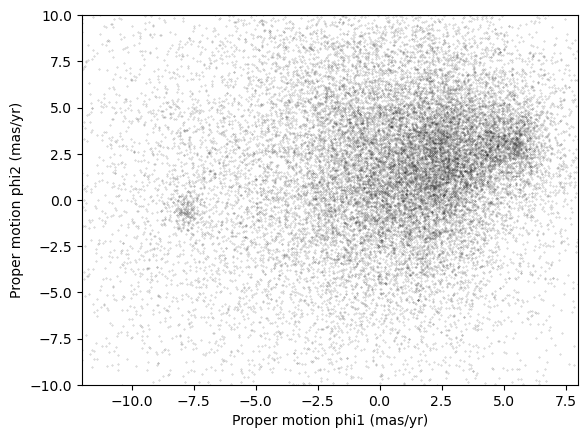

In [45]:
plot_proper_motion(centerline_df)

# Filtering based on proper motion

The next step is to select stars in the “overdense” region of proper motion, which are candidates to be in GD-1.

Here are bounds on proper motion we chose by eye:

In [46]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

In [47]:
pm1_rect, pm2_rect = make_rectangle(pm1_min, pm1_max, pm2_min, pm2_max)

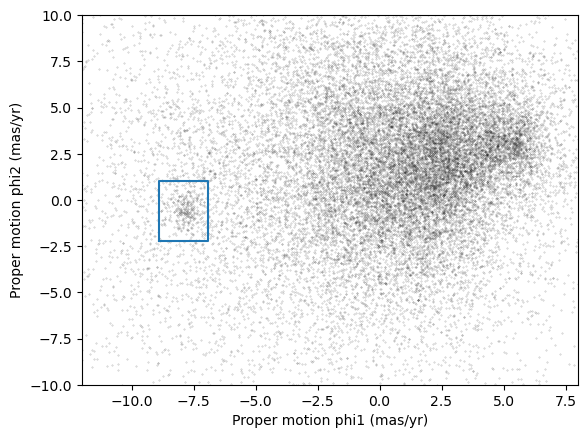

In [48]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect, '-')

Now that we have identified the bounds of the cluster in proper motion, we will use it to select rows from results_df.

We will use the following function, which uses Pandas operators to make a mask that selects rows where series falls between low and high.

In [49]:
def between(series, low, high):
    """Check whether values are between `low` and `high`."""
    return (series > low) & (series < high)

In [50]:
pm1 = results_df['pm_phi1'] # proper motion in phi1 direction not coordinates
pm2 = results_df['pm_phi2'] # proper motion in phi2 direction not coordinates

pm_mask = (between(pm1, pm1_min, pm1_max) & 
           between(pm2, pm2_min, pm2_max))

In [51]:
pm_mask.sum()

1049

Now we can use this mask to select rows from results_df.

In [52]:
selected_df = results_df[pm_mask]

These are the stars we think are likely to be in GD-1. We can inspect these stars, plotting their coordinates (not their proper motion).

Text(0, 0.5, 'phi2 (degree GD1)')

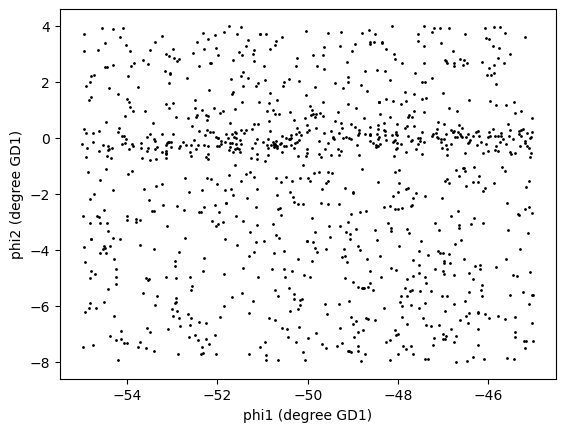

In [53]:
x = selected_df['phi1']
y = selected_df['phi2']
plt.plot(x, y, 'ko', markersize=1, alpha=1)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)')

To clean up the plot a little bit we can add two new Matplotlib commands:

axis with the parameter equal sets up the axes so a unit is the same size along the x and y axes.

title puts the input string as a title at the top of the plot. The fontsize keyword sets the fontsize to be medium, a little smaller than the default large.

In an example like this, where x and y represent coordinates in space, equal axes ensures that the distance between points is represented accurately. Since we are now constraining the relative proportions of our axes, the data may not fill the entire figure.

(-55.4928032130903, -44.503699550734694, -8.606246809552179, 4.601299340488258)

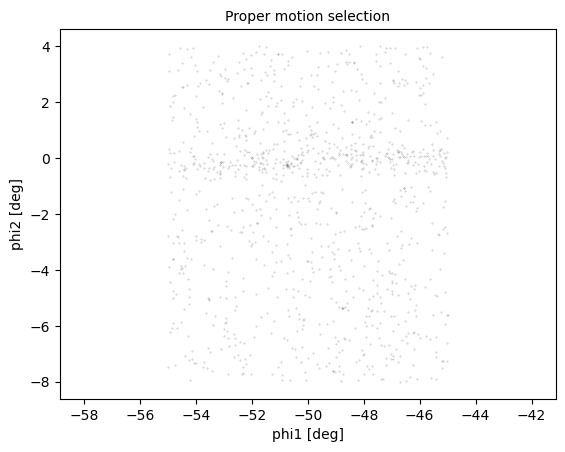

In [54]:
x = selected_df['phi1']
y = selected_df['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('phi1 [deg]')
plt.ylabel('phi2 [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.axis('equal')

Before we go any further, we will put the code we wrote to make one of the panel figures into a function that we will use in future episodes to recreate this entire plot with a single line of code.

In [55]:
def plot_pm_selection(df):
    """Plot in GD-1 spatial coordinates the location of the stars
    selected by proper motion
    """
    x = df['phi1']
    y = df['phi2']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('phi1 [deg]')
    plt.ylabel('phi2 [deg]')
    plt.title('Proper motion selection', fontsize='medium')

    plt.axis('equal')

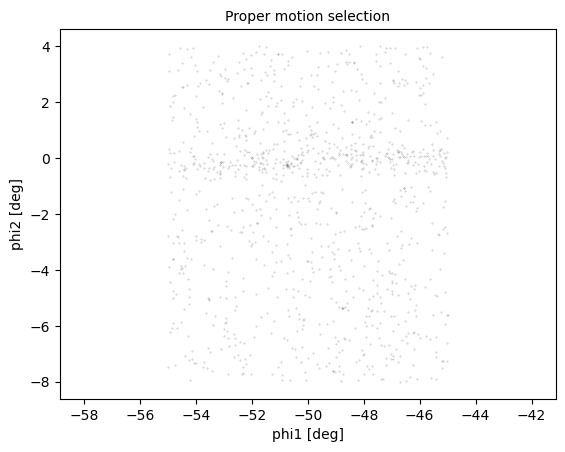

In [56]:
plot_pm_selection(selected_df)

# Saving Data Frame

Because an HDF5 file can contain more than one Dataset, we have to provide a name, or “key”, that identifies the Dataset in the file.

We could use any string as the key, but it is generally a good practice to use a descriptive name (just like your DataFrame variable name) so we will give the Dataset in the file the same name (key) as the DataFrame.

In [57]:
filename = 'gd1_data.hdf'

selected_df.to_hdf(filename, 'selected_df')

We are going to need centerline_df later as well. Write a line of code to add it as a second Dataset in the HDF5 file.

In [58]:
centerline_df.to_hdf(filename, 'centerline_df')

If you forget what the names of the Datasets in the file are, you can read them back like this:

In [60]:
import pandas as pd
with pd.HDFStore(filename) as hdf:
    print(hdf.keys())

['/centerline_df', '/results_df', '/selected_df']


# Selection by Proper Motion

First, we will verify that our proper motion selection was correct, starting with the plot_proper_motion function that we defined in episode 3. The following figure shows:

Proper motion for the stars we selected along the center line of GD-1,

The rectangle we selected, and

The stars inside the rectangle highlighted in green.

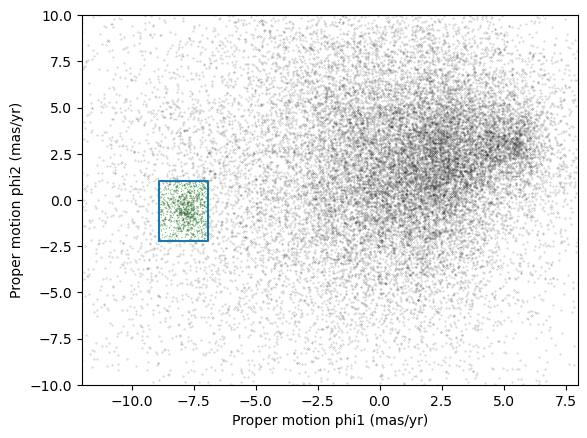

In [62]:
plot_proper_motion(centerline_df)

plt.plot(pm1_rect, pm2_rect)

x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3)

Now we will make the same plot using proper motions in the ICRS frame, which are stored in columns named pmra and pmdec.

(-20.0, 5.0)

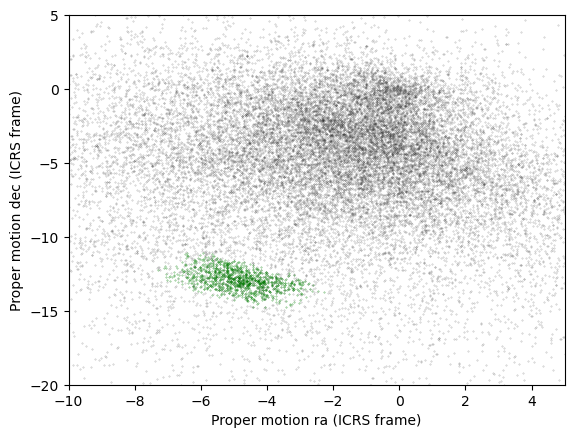

In [64]:
x = centerline_df['pmra']
y = centerline_df['pmdec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=1, alpha=0.3)
    
plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5])

# Assembling the query

In this episode we will make two changes:

1. We will select stars with coordinates in a larger region to include more of GD-1.

2. We will add another clause to select stars whose proper motion is in the range we just defined in the previous exercise.

The fact that we remove most contaminating stars with the proper motion filter is what allows us to expand our query to include most of GD-1 without returning too many results. As we did in episode 2, we will define the physical region we want to select in the GD-1 frame and transform it to the ICRS frame to query the Gaia catalog which is in the ICRS frame.

Here are the coordinates of the larger rectangle in the GD-1 frame.

In [66]:
phi1_min = -70 * u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree

We selected these bounds by trial and error, defining the largest region we can process in a single query.

In [67]:
phi1_rect, phi2_rect = make_rectangle(phi1_min, phi1_max, phi2_min, phi2_max)

Here is how we transform it to ICRS

In [68]:
corners = SkyCoord(phi1=phi1_rect, 
                   phi2=phi2_rect, 
                   frame=gd1_frame)

corners_icrs = corners.transform_to('icrs')

To use corners_icrs as part of an ADQL query, we have to convert it to a string. Fortunately, we wrote a function, skycoord_to_string to do this

In [69]:
sky_point_list = skycoord_to_string(corners_icrs)
sky_point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

In [70]:
columns = 'source_id, ra, dec, pmra, pmdec'

Now let us just cross-check what we want to query

In [71]:
candidate_coord_query = candidate_coord_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list)
print(candidate_coord_query)

SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



In [75]:
candidate_coord_pm_query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({sky_point_list}))
  AND pmra BETWEEN {pmra_min} AND  {pmra_max}
  AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

In [83]:
pmra_min=-6.7
pmra_max=-3
pmdec_min=-14.31
pmdec_max=-11.2

In [84]:
candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns, 
                            sky_point_list=sky_point_list,
                            pmra_min=-6.7,
                            pmra_max=-3,
                            pmdec_min=-14.31,
                            pmdec_max=-11.2)
print(candidate_coord_pm_query)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND pmra BETWEEN -6.7 AND  -3
  AND pmdec BETWEEN -14.31 AND -11.2



In [80]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)
print(candidate_coord_pm_job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=8409>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1681297702753O
Phase: COMPLETED
Owner: None
Output file: async_20230412163822.vot
Results: None


In [81]:
candidate_gaia_table = candidate_coord_pm_job.get_results()
len(candidate_gaia_table)

8409

ADQL intends the POLYGON function to only be used on coordinates and not on proper motion. To enforce this, it will produce an error when a negative value is passed into the first argument.

We call the results candidate_gaia_table because it contains information from the Gaia table for stars that are good candidates for GD-1.

To save them to an HDF5 file we first need to put them in a Pandas object. We have seen how to create a Series from a column in a DataFrame. Now we will build a Series from scratch. We do not need the full DataFrame format with multiple rows and columns because we are only storing one string (sky_point_list). We can store each string as a row in the Series and save it. One aspect that is nice about Series is that we can label each row. To do this we need an object that can define both the name of each row and the data to go in that row. We can use a Python Dictionary for this, defining the row names with the dictionary keys and the row data with the dictionary values.

In [85]:
d = dict(sky_point_list=sky_point_list, pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min, pmdec_max=pmdec_max)
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -6.7,
 'pmra_max': -3,
 'pmdec_min': -14.31,
 'pmdec_max': -11.2}

In [86]:
point_series = pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                       -6.7
pmra_max                                                         -3
pmdec_min                                                    -14.31
pmdec_max                                                     -11.2
dtype: object

In [87]:
filename = 'gd1_data.hdf'
point_series.to_hdf(filename, 'point_series')

/var/folders/7d/s9h888js3wg44h10jbwk1l1r0000gn/T/ipykernel_56556/1683950938.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  point_series.to_hdf(filename, 'point_series')


Warning:
This is because in the Series we just created, we are mixing variables of different types: sky_point_list is a string (text), whereas pmra_min etc. are floating point numbers. While combining different data types in a single Series is somewhat inefficient, the amount of data is small enough to not matter in this case, so this warning can be safely ignored.

# Plotting one more time

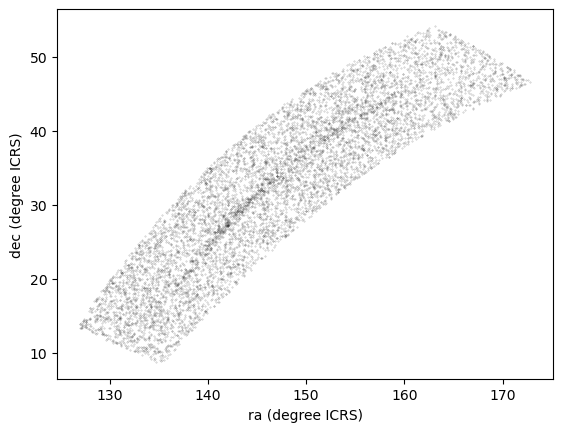

In [88]:
x = candidate_gaia_table['ra']
y = candidate_gaia_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

This plot shows why it was useful to transform these coordinates to the GD-1 frame. In ICRS, it is more difficult to identity the stars near the centerline of GD-1.

We can use our make_dataframe function from episode 3 to transform the results back to the GD-1 frame. In addition to doing the coordinate transformation and reflex correction for us, this function also compiles everything into a single object (a DataFrame) to make it easier to use. Note that because we put this code into a function, we can do all of this with a single line of code!

In [89]:
candidate_gaia_df = make_dataframe(candidate_gaia_table)

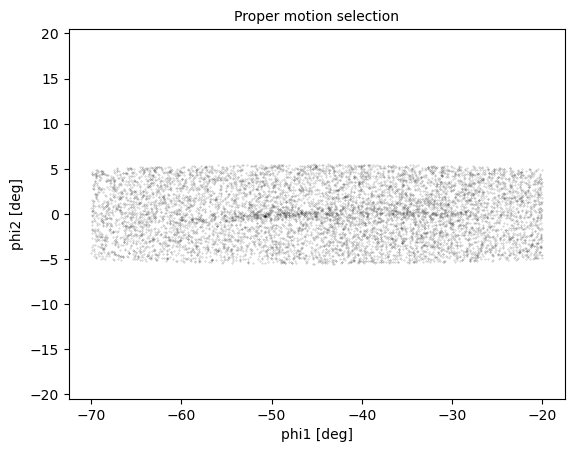

In [90]:
plot_pm_selection(candidate_gaia_df)

# Getting photometry data

Stars in the Gaia dataset are identified by source_id.

Stars in the Pan-STARRS dataset are identified by obj_id.

For each candidate star we have selected so far, we have the source_id; the goal is to find the obj_id for the same star in the Pan-STARRS catalog.

To do that we will:

Use the JOIN operator to look up each Pan-STARRS obj_id for the stars we are interested in in the panstarrs1_best_neighbour table using the source_ids that we have already identified.

Use the JOIN operator again to look up the Pan-STARRS photometry for these stars in the panstarrs1_original_valid table using the obj_ids we just identified.

Before we get to the JOIN operation, we will explore these tables.

In [91]:
ps_best_neighbour_meta = Gaia.load_table('gaiadr2.panstarrs1_best_neighbour')

Retrieving table 'gaiadr2.panstarrs1_best_neighbour'


In [92]:
print(ps_best_neighbour_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_best_neighbour
Description: Pan-STARRS1 BestNeighbour table lists each matched Gaia object with its
best neighbour in the external catalogue.
There are 1 327 157 objects in the filtered version of Pan-STARRS1 used
to compute this cross-match that have too early epochMean.
Num. columns: 7


To print Column Names

In [93]:
for column in ps_best_neighbour_meta.columns:
    print(column.name)

source_id
original_ext_source_id
angular_distance
number_of_neighbours
number_of_mates
best_neighbour_multiplicity
gaia_astrometric_params


Documentation for these variables: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_crossmatches/ssec_dm_panstarrs1_best_neighbour.html

The ones we will use are:

source_id, which we will match up with source_id in the Gaia table.

best_neighbour_multiplicity, which indicates how many sources in Pan-STARRS are matched with the same probability to this source in Gaia.

number_of_mates, which indicates the number of other sources in Gaia that are matched with the same source in Pan-STARRS.

original_ext_source_id, which we will match up with obj_id in the Pan-STARRS table.

Ideally, best_neighbour_multiplicity should be 1 and number_of_mates should be 0; in that case, there is a one-to-one match between the source in Gaia and the corresponding source in Pan-STARRS.